### **Import Libraries**

In [43]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch.utils.data import random_split
from torch import optim
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **Load Dataset**

In [45]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 train set
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Load the CIFAR-10 test set
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train_dataset into train and validation datasets
n_valid = int(0.1 * len(train_dataset))
n_train = len(train_dataset) - n_valid
train_dataset, val_dataset = random_split(train_dataset, [n_train, n_valid])

# Define batch size
batch_size = 64

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_loader


Files already downloaded and verified
Files already downloaded and verified


### **View the dataset**

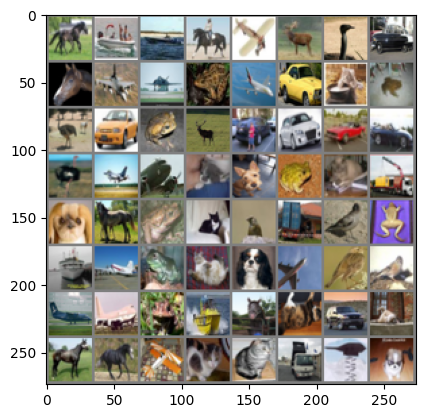

tensor(7) tensor(8) tensor(8) tensor(7) tensor(0) tensor(4) tensor(2) tensor(1) tensor(7) tensor(0) tensor(0) tensor(6) tensor(0) tensor(1) tensor(3) tensor(6) tensor(2) tensor(1) tensor(6) tensor(4) tensor(1) tensor(1) tensor(1) tensor(1) tensor(2) tensor(0) tensor(0) tensor(3) tensor(5) tensor(6) tensor(3) tensor(9) tensor(5) tensor(7) tensor(6) tensor(3) tensor(2) tensor(9) tensor(2) tensor(6) tensor(8) tensor(0) tensor(6) tensor(3) tensor(5) tensor(0) tensor(2) tensor(2) tensor(0) tensor(0) tensor(6) tensor(8) tensor(7) tensor(3) tensor(1) tensor(3) tensor(7) tensor(7) tensor(0) tensor(3) tensor(3) tensor(9) tensor(0) tensor(5)


In [46]:
# Function to unnormalize and display an image
def visualize_data(i):
    i = i / 2 + 0.5
    plt.imshow(np.transpose(i.numpy(), (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
visualize_data(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%5s' % labels[j] for j in range(batch_size)))


# **Defining the functions will be used for both the models**

---



### **Visualize the test results**

In [47]:
# Define a function to visualize predicted and actual labels
def visualize_predictions(inputs, predictions, true_labels, class_names, t):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.imshow(inputs[i].permute(1, 2, 0).cpu().numpy())
        ax.set_title(f'Predicted: {class_names[predictions[i]]}\nActual: {class_names[true_labels[i]]}')
        ax.axis('off')

    plt.suptitle(f'Model {t}: Predicted labels', fontsize=16)
    plt.tight_layout()
    plt.show()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### **Confusion Matrix**

In [48]:
# Generate the confusion matrix
def view_confusion_matrix(test_label, test_pred):
  return confusion_matrix(test_label, test_pred)

### **Train and validation loss**

In [60]:
def train(num_epochs, model, train_loader, val_loader, criterion, optimizer, model_filename='model.pth'):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%")

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                inputs_val = inputs_val.to(device)
                labels_val = labels_val.to(device)

                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, labels_val)
                val_loss += loss_val.item()

                _, predicted_val = torch.max(outputs_val, 1)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == labels_val).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Save the model at the end of each epoch
        torch.save(model.state_dict(), model_filename)

        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies


### **Train and Validation Loss Vs Epochs**

In [50]:
def plot(train_loss, validation_loss):
  # Plotting the training and validation losses
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, num_epochs+1), train_loss, label='Train Loss')
  plt.plot(range(1, num_epochs+1), validation_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Losses')
  plt.legend()
  plt.show()

### **Evaluate the model**

In [51]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    preds = []
    true_labels = []
    inputs = []

    with torch.no_grad():
        for batch in test_loader:
            images, labels_batch = batch
            images = images.to(device)
            labels_batch = labels_batch.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels_batch.size(0)
            correct += (predicted == labels_batch).sum().item()
            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels_batch.cpu().numpy())
            inputs.extend(images.cpu().numpy())

    accuracy = correct / total
    inputs = torch.tensor(inputs)
    return accuracy, np.array(preds), np.array(true_labels), inputs

# **Model 1: Depth-wise and Point-wise Convolution**

---



In [52]:
class DepthAndPointWiseConvolution(nn.Module):
    def __init__(self):
        super(DepthAndPointWiseConvolution, self).__init__()

        # Convolution layer 1
        self.convolution_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=2, groups=3),
            nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Convolution layer 2
        self.convolution_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, groups=64),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Convolution layer 3
        self.convolution_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, groups=128),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Convolution layer 4
        self.convolution_4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, groups=256),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # Linear layer
        self.linear = nn.Linear(512 * 1 * 1, 10)

    def forward(self, x):
        x = self.convolution_1(x)
        x = self.convolution_2(x)
        x = self.convolution_3(x)
        x = self.convolution_4(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        out = self.linear(x)
        out = F.softmax(out, dim=1)

        return out


In [53]:
model_1 = DepthAndPointWiseConvolution().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr = 0.001)

#### **Train and Validation loss**

In [61]:
num_epochs = 10
train_losses_1, val_losses_1, train_acc_1, val_acc_1 = train(num_epochs, model_1, train_loader, val_loader, criterion, optimizer)

Epoch 1/10, Train Loss: 1.8047, Train Accuracy: 65.54%
Epoch 1/10, Validation Loss: 1.8154, Validation Accuracy: 64.48%
Epoch 2/10, Train Loss: 1.7949, Train Accuracy: 66.44%
Epoch 2/10, Validation Loss: 1.8039, Validation Accuracy: 65.54%
Epoch 3/10, Train Loss: 1.7894, Train Accuracy: 66.94%
Epoch 3/10, Validation Loss: 1.8109, Validation Accuracy: 64.86%
Epoch 4/10, Train Loss: 1.7858, Train Accuracy: 67.37%
Epoch 4/10, Validation Loss: 1.8030, Validation Accuracy: 65.62%
Epoch 5/10, Train Loss: 1.7769, Train Accuracy: 68.34%
Epoch 5/10, Validation Loss: 1.7967, Validation Accuracy: 66.22%
Epoch 6/10, Train Loss: 1.7702, Train Accuracy: 68.87%
Epoch 6/10, Validation Loss: 1.8080, Validation Accuracy: 65.36%
Epoch 7/10, Train Loss: 1.7697, Train Accuracy: 69.01%
Epoch 7/10, Validation Loss: 1.7950, Validation Accuracy: 66.00%
Epoch 8/10, Train Loss: 1.7604, Train Accuracy: 69.92%
Epoch 8/10, Validation Loss: 1.7899, Validation Accuracy: 66.94%
Epoch 9/10, Train Loss: 1.7546, Train Ac

#### **Train and Validation loss VS Epochs**

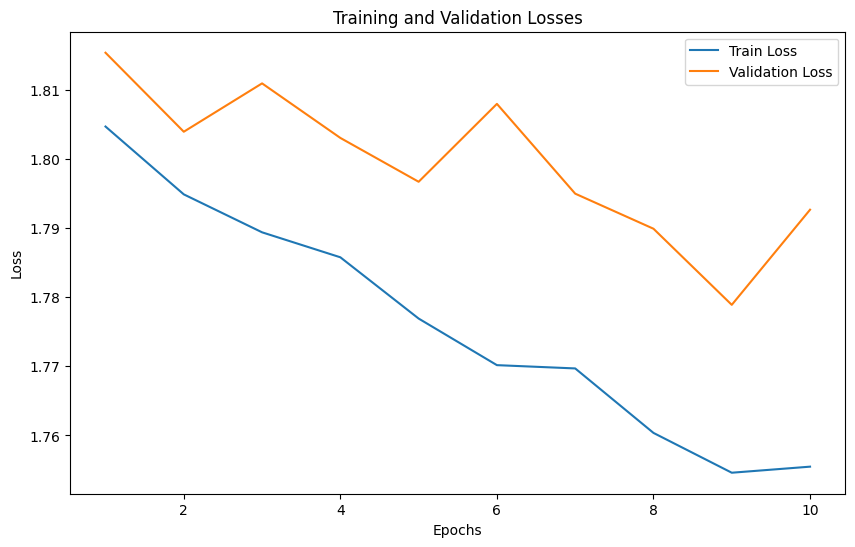

In [62]:
plot(train_losses_1, val_losses_1)

#### **Evaluating model**

In [63]:
test_accuracy_1, test_pred_1, test_labels_1, inputs_1 = evaluate_model(model_1, test_loader)
print(f'Test Accuracy: {test_accuracy_1*100:.3f}%')

Test Accuracy: 67.790%


# **Model 2: Traditional Convolution Model**

---



In [64]:
class TraditionalConvolution(nn.Module):
    def __init__(self):
        super(TraditionalConvolution, self).__init__()

        # Convolution layer 1
        self.convolution_1 = nn.Sequential(
            nn.Conv2d(in_channels=3 , out_channels=64, kernel_size = 2, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Convolution layer 2
        self.convolution_2 = nn.Sequential(
            nn.Conv2d(in_channels=64 , out_channels=128, kernel_size = 2, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Convolution layer 3
        self.convolution_3 = nn.Sequential(
            nn.Conv2d(in_channels=128 , out_channels=256, kernel_size = 2, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Convolution layer 4
        self.convolution_4 = nn.Sequential(
            nn.Conv2d(in_channels=256 , out_channels=512, kernel_size = 2, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # Linear layer
        self.linear = nn.Linear(512 * 4 * 4, 10)

    def forward(self, x):
        x = self.convolution_1(x)
        x = self.convolution_2(x)
        x = self.convolution_3(x)
        x = self.convolution_4(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        out = self.linear(x)
        out = F.softmax(out, dim=1)

        return out


In [65]:
model_2 = TraditionalConvolution().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr = 0.001)

#### **Train and Validation Loss**

In [66]:
train_losses_2, val_losses_2, train_acc_2, val_acc_2 = train(num_epochs, model_2, train_loader, val_loader, criterion, optimizer)

Epoch 1/10, Train Loss: 2.1221, Train Accuracy: 33.02%
Epoch 1/10, Validation Loss: 2.0603, Validation Accuracy: 39.70%
Epoch 2/10, Train Loss: 2.0326, Train Accuracy: 42.32%
Epoch 2/10, Validation Loss: 2.0015, Validation Accuracy: 45.30%
Epoch 3/10, Train Loss: 1.9866, Train Accuracy: 46.90%
Epoch 3/10, Validation Loss: 1.9585, Validation Accuracy: 49.62%
Epoch 4/10, Train Loss: 1.9546, Train Accuracy: 50.36%
Epoch 4/10, Validation Loss: 1.9475, Validation Accuracy: 51.18%
Epoch 5/10, Train Loss: 1.9315, Train Accuracy: 52.56%
Epoch 5/10, Validation Loss: 1.9253, Validation Accuracy: 53.50%
Epoch 6/10, Train Loss: 1.9028, Train Accuracy: 55.49%
Epoch 6/10, Validation Loss: 1.8973, Validation Accuracy: 55.96%
Epoch 7/10, Train Loss: 1.8830, Train Accuracy: 57.54%
Epoch 7/10, Validation Loss: 1.8690, Validation Accuracy: 58.72%
Epoch 8/10, Train Loss: 1.8684, Train Accuracy: 58.97%
Epoch 8/10, Validation Loss: 1.8539, Validation Accuracy: 60.42%
Epoch 9/10, Train Loss: 1.8464, Train Ac

#### **Plot between validation and train loss VS Epochs**

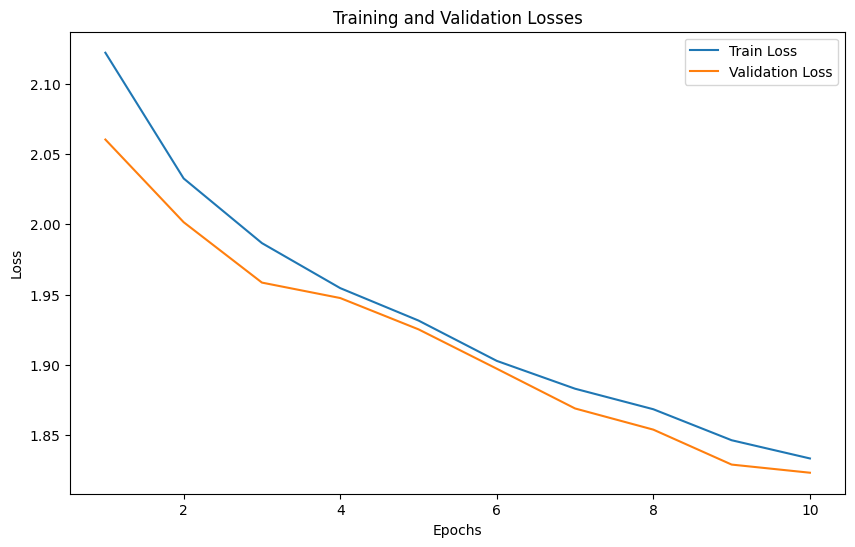

In [67]:
plot(train_losses_2, val_losses_2)

#### **Evaluating Model**

In [68]:
test_accuracy_2, test_pred_2, test_labels_2, inputs_2 = evaluate_model(model_2, test_loader)
print(f'Test Accuracy: {test_accuracy_2*100:.3f}%')

Test Accuracy: 63.150%


# **Comparing the model**

---



### **Accuracy Comparision**

In [69]:
# Accuracy comparision
print("Accuracy for Depthwise aand Pointwise convolution neural network", test_accuracy_1)
print("Accuracy for Traditional convolution neural network", test_accuracy_2)

Accuracy for Depthwise aand Pointwise convolution neural network 0.6779
Accuracy for Traditional convolution neural network 0.6315


### **Classification Report**

In [70]:
# Report for model 1
class_report_1 = classification_report(test_labels_1, test_pred_1)
print("Model 1:")
print(class_report_1)

# Report for model 2
class_report_2 = classification_report(test_labels_2, test_pred_2)
print("Model 2:")
print(class_report_2)

Model 1:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71      1000
           1       0.80      0.79      0.80      1000
           2       0.60      0.48      0.54      1000
           3       0.50      0.53      0.51      1000
           4       0.63      0.61      0.62      1000
           5       0.61      0.58      0.60      1000
           6       0.73      0.77      0.75      1000
           7       0.69      0.72      0.70      1000
           8       0.73      0.84      0.78      1000
           9       0.75      0.74      0.75      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000

Model 2:
              precision    recall  f1-score   support

           0       0.61      0.77      0.68      1000
           1       0.77      0.82      0.80      1000
           2       0.52      0.48      0.50      1000
      

### **Confusion Matrix Comparision**

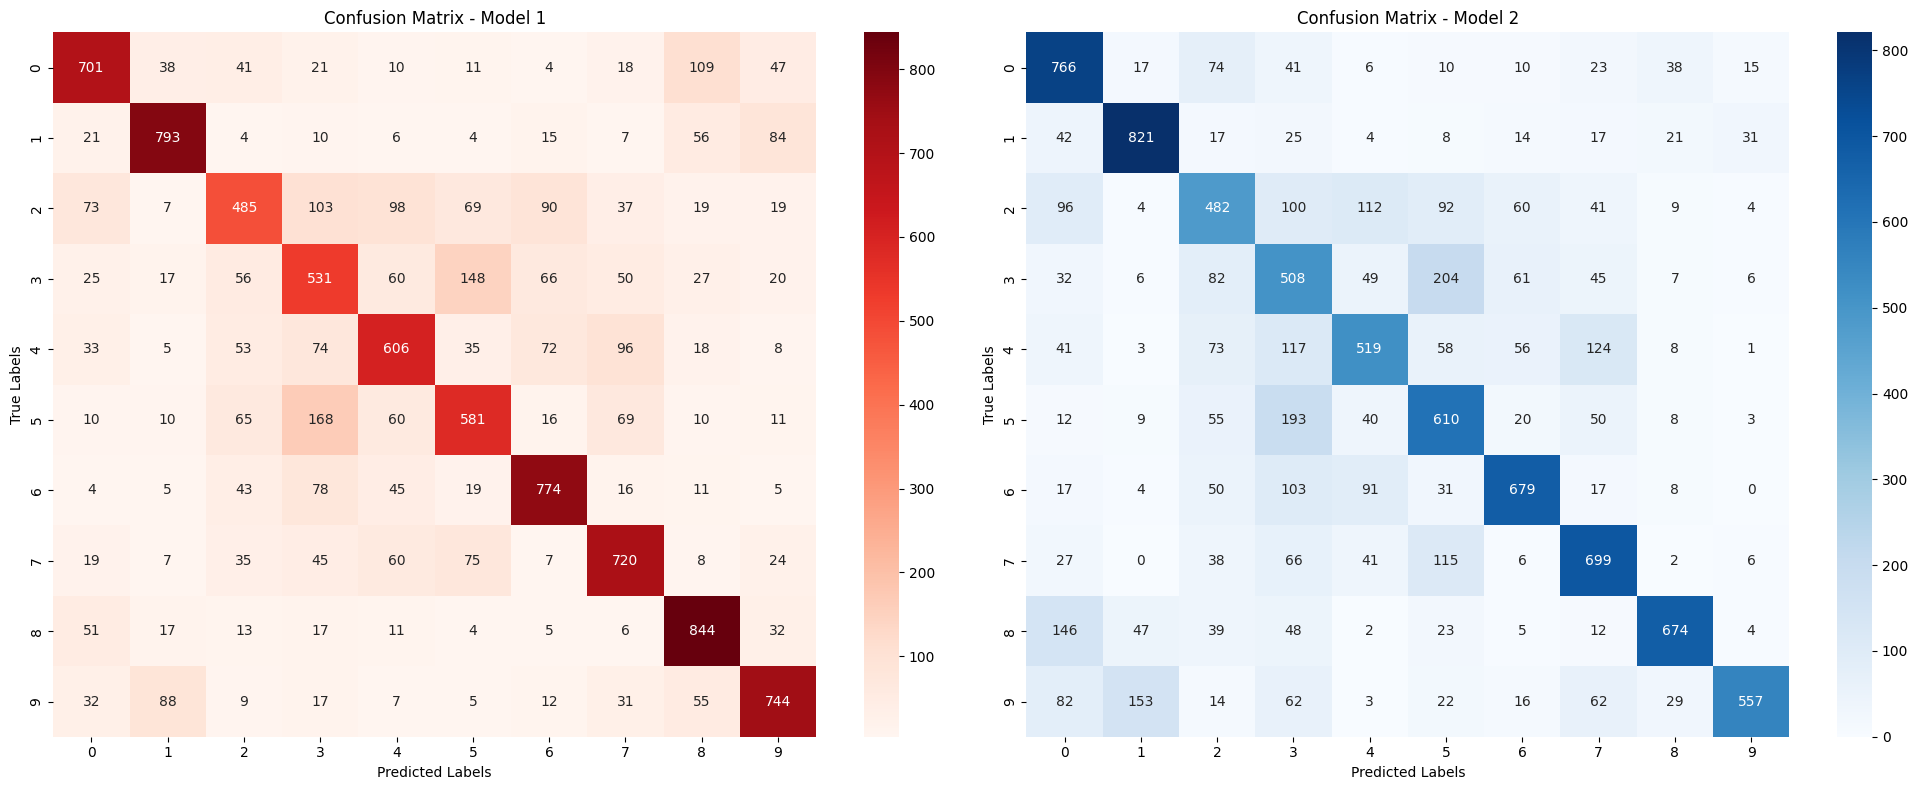

In [71]:
confusion_matrix_1 = view_confusion_matrix(test_labels_1, test_pred_1)
confusion_matrix_2 = view_confusion_matrix(test_labels_2, test_pred_2)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot confusion matrix for model 1
sns.heatmap(confusion_matrix_1, annot=True, fmt="d", cmap="Reds", xticklabels=range(10), yticklabels=range(10), ax=axes[0])
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")
axes[0].set_title("Confusion Matrix - Model 1")

# Plot confusion matrix for model 2
sns.heatmap(confusion_matrix_2, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10), ax=axes[1])
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("True Labels")
axes[1].set_title("Confusion Matrix - Model 2")

plt.tight_layout()
plt.show()

### **Visualize the test results**

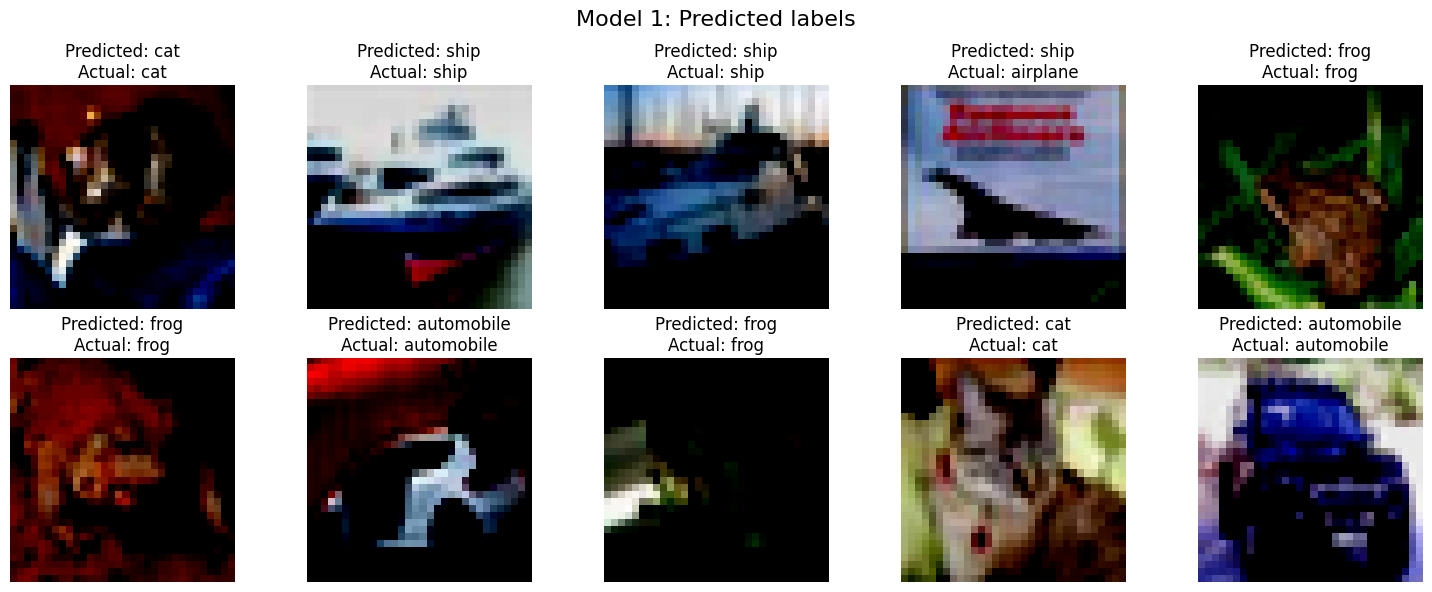

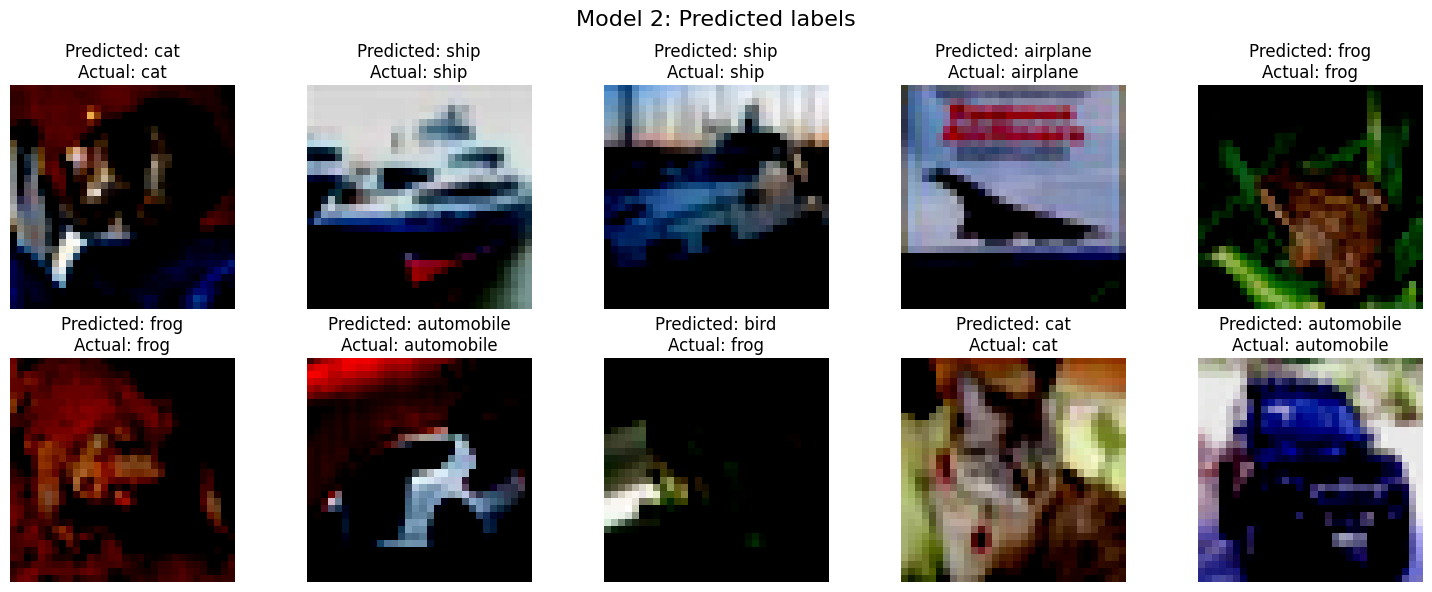

In [72]:
# Visualize model 1
visualize_predictions(inputs_1, test_pred_1, test_labels_1, class_names, 1)

# Visualize model 2
visualize_predictions(inputs_2, test_pred_2, test_labels_2, class_names, 2)

### **Train Accuracy comparison between the models**

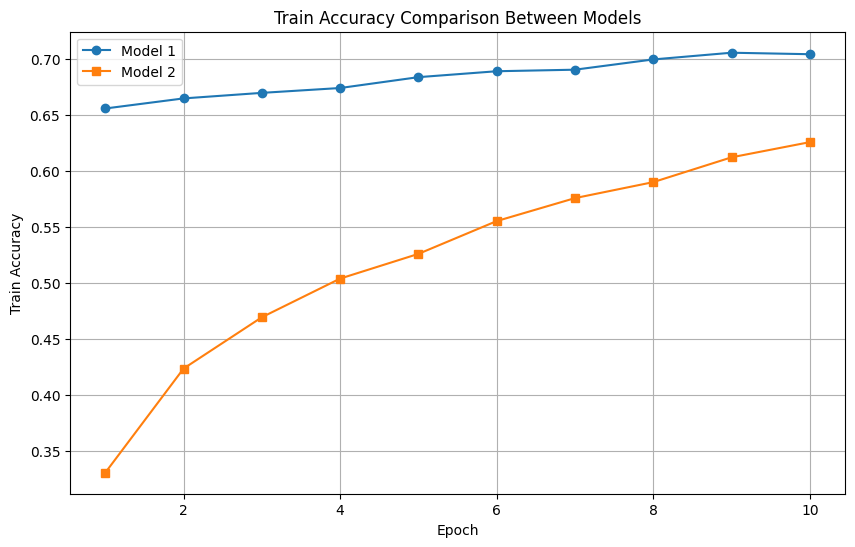

In [73]:
epochs = range(1, len(train_acc_1) + 1)  # Assuming metric_values_model1 and metric_values_model2 have the same length

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_1, label='Model 1', marker='o')
plt.plot(epochs, train_acc_2, label='Model 2', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy Comparison Between Models')
plt.legend()
plt.grid(True)
plt.show()

# **Observation And Analysis**
---


- **Accuracy Comparison**:
  - Model 1 (Depthwise and Pointwise Convolution) achieves an accuracy of 68%, while Model 2 (Traditional Convolution) achieves 63%. This indicates that Model 1 performs slightly better overall in correctly classifying images compared to Model 2.

- **Precision, Recall, and F1-score**:
  - Model 1 generally demonstrates higher precision, recall, and F1-score across most classes compared to Model 2. This suggests that Model 1 is better at correctly identifying positive instances (precision), capturing relevant instances (recall), and achieving a balance between precision and recall (F1-score) for various classes.
  - However, Model 2 outperforms Model 1 in certain classes, such as Class 0 (airplane) and Class 9 (truck), indicating that Model 2 might have a better ability to correctly classify specific types of images within these classes.

- **Analysis**:

  - Model 1's higher precision, recall, and F1-score across most classes suggest that its Depthwise and Pointwise Convolution layers enable it to capture more complex patterns and relationships within the data compared to the Traditional Convolution used in Model 2.
  - The Depthwise and Pointwise Convolution operations in Model 1 likely allow it to extract more informative features, leading to better discrimination between different classes and improved overall performance.

- **Generalization**:
  - Model 1 appears to generalize better to unseen data compared to Model 2, as evidenced by its higher accuracy and better performance metrics across various classes.
  - The ability of Model 1 to generalize well to new data indicates that its learned features are more robust and transferable, allowing it to perform consistently across different image samples.